<a href="https://colab.research.google.com/github/harmanpreet93/recurrent_neural_networks/blob/master/vanishing_grads_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
dir = '/content/drive/My Drive/DL-assignment-2'
os.chdir(dir)

In [0]:
import argparse
import time
import collections
import os
import sys
import torch
import torch.nn
from torch.autograd import Variable
import torch.nn as nn
import numpy as np

from solution import RNN, GRU
import matplotlib.pyplot as plt

In [3]:
def set_seed(seed):
    # random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(1111)    

# Use the GPU if you have one
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda")
else:
    print("WARNING: You are about to run on cpu, and this will likely run out \
      of memory. \n You can try setting batch_size=1 to reduce memory usage")
    device = torch.device("cpu")

Using the GPU


In [4]:
# HELPER FUNCTIONS
def _read_words(filename):
    with open(filename, "r") as f:
      return f.read().replace("\n", "<eos>").split()

def _build_vocab(filename):
    data = _read_words(filename)

    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    id_to_word = dict((v, k) for k, v in word_to_id.items())

    return word_to_id, id_to_word

def _file_to_word_ids(filename, word_to_id):
    data = _read_words(filename)
    return [word_to_id[word] for word in data if word in word_to_id]

# Processes the raw data from text files
def ptb_raw_data(data_path=None, prefix="ptb"):
    train_path = os.path.join(data_path, prefix + ".train.txt")
    valid_path = os.path.join(data_path, prefix + ".valid.txt")
    test_path = os.path.join(data_path, prefix + ".test.txt")

    word_to_id, id_2_word = _build_vocab(train_path)
    train_data = _file_to_word_ids(train_path, word_to_id)
    valid_data = _file_to_word_ids(valid_path, word_to_id)
    test_data = _file_to_word_ids(test_path, word_to_id)
    return train_data, valid_data, test_data, word_to_id, id_2_word

# Yields minibatches of data
def ptb_iterator(raw_data, batch_size, num_steps):
    raw_data = np.array(raw_data, dtype=np.int32)

    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)
    for i in range(batch_size):
        data[i] = raw_data[batch_len * i:batch_len * (i + 1)]

    epoch_size = (batch_len - 1) // num_steps

    if epoch_size == 0:
        raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

    for i in range(epoch_size):
        x = data[:, i*num_steps:(i+1)*num_steps]
        y = data[:, i*num_steps+1:(i+1)*num_steps+1]
        yield (x, y)

# LOAD DATA
print('Loading data from '+ 'data')
raw_data = ptb_raw_data(data_path='data')
train_data, valid_data, test_data, word_to_id, id_2_word = raw_data
vocab_size = len(word_to_id)
print('  vocabulary size: {}'.format(vocab_size))

Loading data from data
  vocabulary size: 10000


In [5]:
model = RNN(emb_size=200, 
            hidden_size=512,
            seq_len=35, 
            batch_size=128,
            vocab_size=10000, 
            num_layers=2,
            dp_keep_prob=0.8)

path = "/content/drive/My Drive/DL-assignment-2/RNN_SGD_model=RNN_optimizer=SGD_initial_lr=1.0_batch_size=128_seq_len=35_hidden_size=512_num_layers=2_dp_keep_prob=0.8_num_epochs=30_save_best_0/best_params.pt"

model = model.to(device)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
def forward(model, inputs):
    if inputs.is_cuda:
        device = inputs.get_device()
    else:
        device = torch.device("cpu")

    # Apply the Embedding layer on the input
    embed_out = model.embeddings(inputs)# shape (seq_len,batch_size,emb_size)

    # Create a tensor to store outputs during the Forward
    logits = torch.zeros(model.seq_len, model.batch_size, model.vocab_size).to(device)
    
    # Create a tensor to store outputs during the Forward
    AllHiddenStates = []
    HiddenStateAtTimeT = []
    for layer in range(model.num_layers):
        hidden = torch.zeros(model.batch_size, model.hidden_size).to(device)
        hidden.requires_grad = True
        hidden.retain_grad()
        HiddenStateAtTimeT.append(hidden)
    AllHiddenStates.append(HiddenStateAtTimeT)
    
    for timestep in range(model.seq_len):
        input_ = embed_out[timestep]
        
        NewHiddenStatesAtTimeT = []
        CurrentHiddenStatesAtTimeT = AllHiddenStates[timestep]
        
        for layer in range(model.num_layers):
            hidden = torch.tanh(model.layers[layer](torch.cat([input_, CurrentHiddenStatesAtTimeT[layer]], 1)))
            hidden.retain_grad()
            NewHiddenStatesAtTimeT.append(hidden)
            input_ = hidden
        
        logits[timestep] = model.out_layer(input_)
        AllHiddenStates.append(NewHiddenStatesAtTimeT)
    return logits, AllHiddenStates

In [13]:
Norms = []
model.train()
loss_fn = nn.CrossEntropyLoss()
for step, (x, y) in enumerate(ptb_iterator(train_data, model.batch_size, model.seq_len)):
    inputs = torch.from_numpy(x.astype(np.int64)).transpose(0, 1).contiguous().to(device)#.cuda()
    model.zero_grad()
    outputs, hidden = forward(model, inputs)
    targets = torch.from_numpy(y.astype(np.int64)).transpose(0, 1).contiguous().to(device)#.cuda()
    targets = targets[model.seq_len-1,:]
    outputs = outputs[model.seq_len-1,:,:]
    tt = torch.squeeze(targets.view(-1, model.batch_size))
    loss = loss_fn(outputs.contiguous().view(-1, model.vocab_size), tt)
    loss.backward()
    print(targets.shape,outputs.shape)
    print(len(hidden),tt.shape,loss)
    print(len(hidden[0]))
    print(hidden[0][0].grad.shape,hidden[10][0].grad.shape,torch.sum(hidden[0][0].grad, dim=0).shape)
    for index in range(model.seq_len):
        norm_of_grad = torch.norm(torch.sum(hidden[index][1].grad, dim=0)/model.batch_size)
        # print(norm_of_grad.data.cpu().numpy())
        Norms.append(norm_of_grad.data.cpu().numpy())
    break

torch.Size([128]) torch.Size([128, 10000])
36 torch.Size([128]) tensor(5.2536, device='cuda:0', grad_fn=<NllLossBackward>)
2
torch.Size([128, 512]) torch.Size([128, 512]) torch.Size([512])


In [0]:
# save grads
np.save('rnnHiddenGradNorm.npy', np.array(Norms))

In [16]:
model = GRU(emb_size=200, 
            hidden_size=512,
            seq_len=35, 
            batch_size=128,
            vocab_size=10000, 
            num_layers=2,
            dp_keep_prob=0.5)

path = "/content/drive/My Drive/DL-assignment-2/GRU_ADAM_model=GRU_optimizer=ADAM_initial_lr=0.001_batch_size=128_seq_len=35_hidden_size=512_num_layers=2_dp_keep_prob=0.5_num_epochs=30_save_best_0/best_params.pt"
model = model.to(device)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
def forward(model, inputs):
    if inputs.is_cuda:
        device = inputs.get_device()
    else:
        device = torch.device("cpu")

    # Apply the Embedding layer on the input
    embed_out = model.word_embeddings(inputs)# shape (seq_len,batch_size,emb_size)

    # Create a tensor to store outputs during the Forward
    logits = torch.zeros(model.seq_len, model.batch_size, model.vocab_size).to(device)

    # Create a tensor to store outputs during the Forward
    AllHiddenStates = []
    HiddenStateAtTimeT = []
    for layer in range(model.num_layers):
        hidden = torch.zeros(model.batch_size, model.hidden_size).to(device)
        hidden.requires_grad = True
        hidden.retain_grad()
        HiddenStateAtTimeT.append(hidden)
    AllHiddenStates.append(HiddenStateAtTimeT)
            
    # For each time step
    for timestep in range(model.seq_len):
        # Apply dropout on the embedding result
        input_ = embed_out[timestep]
        # For each layer

        NewHiddenStatesAtTimeT = []
        CurrentHiddenStatesAtTimeT = AllHiddenStates[timestep]
        
        for layer in range(model.num_layers):
            # Pass through reset gate layer
            r_t = torch.sigmoid(model.r[layer](torch.cat([input_, CurrentHiddenStatesAtTimeT[layer]], 1)))
            # Pass through forget gate layer
            z_t = torch.sigmoid(model.z[layer](torch.cat([input_, CurrentHiddenStatesAtTimeT[layer]], 1)))
            # Pass through hidden layer
            h_t = torch.tanh(model.h[layer](torch.cat([input_, torch.mul(r_t, CurrentHiddenStatesAtTimeT[layer].clone())], 1)))
            # Calculate the hidden states
            hidden = torch.add(torch.mul((1-z_t),hidden[layer].clone()), torch.mul(z_t, h_t))
            # Apply dropout on this layer, but not for the recurrent units
            hidden.retain_grad()
            NewHiddenStatesAtTimeT.append(hidden)
            input_ = hidden
        # Store the output of the time step
        logits[timestep] = model.out_layer(input_)  

        AllHiddenStates.append(NewHiddenStatesAtTimeT)            
    
    return logits, AllHiddenStates

In [19]:
Norms = []
model.train()
loss_fn = nn.CrossEntropyLoss()
for step, (x, y) in enumerate(ptb_iterator(train_data, model.batch_size, model.seq_len)):
    inputs = torch.from_numpy(x.astype(np.int64)).transpose(0, 1).contiguous().to(device)#.cuda()
    model.zero_grad()
    outputs, hidden = forward(model, inputs)
    targets = torch.from_numpy(y.astype(np.int64)).transpose(0, 1).contiguous().to(device)#.cuda()
    targets = targets[model.seq_len-1,:]
    outputs = outputs[model.seq_len-1,:,:]
    tt = torch.squeeze(targets.view(-1, model.batch_size))
    loss = loss_fn(outputs.contiguous().view(-1, model.vocab_size), tt)
    loss.backward()
    print(targets.shape,outputs.shape)
    print(len(hidden),tt.shape,loss)
    print(len(hidden[0]))
    print(hidden[0][0].grad.shape,hidden[10][0].grad.shape,torch.sum(hidden[0][0].grad, dim=0).shape)
    for index in range(model.seq_len):
        norm_of_grad = torch.norm(torch.sum(hidden[index][1].grad, dim=0)/model.batch_size)
        # print(norm_of_grad.data.cpu().numpy())
        Norms.append(norm_of_grad.data.cpu().numpy())
    break

torch.Size([128]) torch.Size([128, 10000])
36 torch.Size([128]) tensor(5.8588, device='cuda:0', grad_fn=<NllLossBackward>)
2
torch.Size([128, 512]) torch.Size([128, 512]) torch.Size([512])


In [0]:
# save GRU grads
np.save('gruHiddenGradNorm.npy', np.array(Norms)) 

In [0]:
rnn_grads = np.load('rnnHiddenGradNorm.npy')
gru_grads = np.load('gruHiddenGradNorm.npy')

In [0]:
scaled_rnn_grads = (rnn_grads - np.min(rnn_grads))/(np.max(rnn_grads) - np.min(rnn_grads))
scaled_gru_grads = (gru_grads - np.min(gru_grads))/(np.max(gru_grads) - np.min(gru_grads))

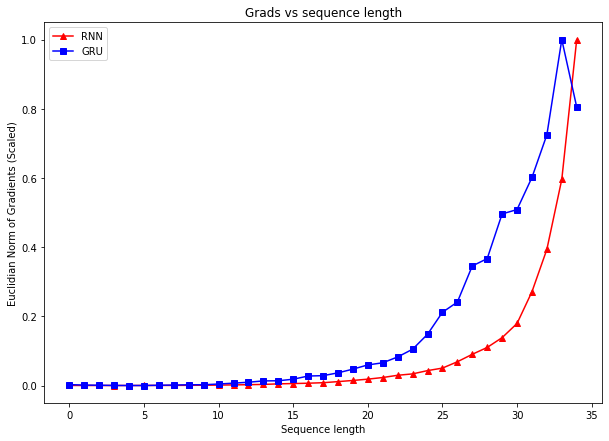

In [37]:
plt.rcParams['figure.figsize'] = [10, 7]
fig, ax = plt.subplots()
ax.plot(scaled_rnn_grads, color='r', label='RNN', marker='^')
ax.plot(scaled_gru_grads, color='b', label='GRU', marker='s')
ax.legend(loc='upper left')
plt.xlabel('Sequence length')
plt.ylabel('Euclidian Norm of Gradients (Scaled)')
plt.title('Grads vs sequence length')
plt.show();